In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import qgrid as qd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=3)
qd.nbinstall(overwrite=True)

ModuleNotFoundError: No module named 'qgrid'

In [4]:
path_to_train_data = '../Data/Robot/robot_train.data'
path_to_test_data = '../Data/Robot/robot_test.data'

In [5]:
def read_data(path_to_data):
    data_dict = {}
    data_panel = None
    color_codes = {'b':0, 'g':1, 'r':2, 'y':3}
    state_codes = {(1, 1):0, (2, 1):1, (3, 1):2, (4, 1):3, (1, 2):4, (2, 2):5, (3, 2):6, (4, 2):7, (1, 3):8, (2, 3):9, (3, 3):10, (4, 3):11, (1, 4):12, (2, 4):13, (3, 4):14, (4, 4):15}
    with open(path_to_data) as f:
        seq_ind = 0
        data_dict[seq_ind] = {'x':[], 'y':[], 'col':[], 'state':[]}
        for line in f:
            if '.' in line:
                seq_ind += 1
                data_dict[seq_ind] = {'x':[], 'y':[], 'col':[], 'state':[]}
            else:
                coord, col = line.strip().split(' ')
                x, y = coord.split(':')
                data_dict[seq_ind]['x'].append(int(x))
                data_dict[seq_ind]['y'].append(int(y))
                data_dict[seq_ind]['state'].append(state_codes[int(x), int(y)])
                data_dict[seq_ind]['col'].append(color_codes[col])
        data_panel = pd.Panel(data_dict)
    return data_panel

In [6]:
data = read_data(path_to_train_data)
data = data.swapaxes(1,2)

Define the alphabets

In [7]:
A, B, pi = None, None, None  # Transition probabilities, emission probabilities, initial state probabilities
S, V = None, None  # State alphabet, Observation alphabet

Infer the state and obseration alphabets from the test data

In [8]:
# S = np.dstack(np.meshgrid(np.unique(data.ix[:, 1]), np.unique(data.ix[:, 2])))
# S = np.array(list(map(tuple, S.reshape(-1,2))), dtype = np.dtype([('x', 'i1'), ('y', 'i1')]))
# S = S.view(np.recarray)
S = np.unique(data.ix[:, 1])
V = np.unique(data.ix[:, 0])

In [9]:
A, B = pd.DataFrame(np.zeros((S.size, S.size)), index=S, columns=S), pd.DataFrame(np.zeros((S.size, V.size)), index=S, columns=V)
# A, B = np.zeros((S.size, S.size)), np.zeros((S.size, V.size))
pi = pd.Series(np.zeros(S.size), index=S)

## Find values of A, B, and pi

In [10]:
obs = data[:, :2].values
states = data[:, 1].values
count_s_ij = pd.DataFrame(np.zeros((S.size, S.size)), index=S, columns=S)
count_s_i = pd.Series(np.zeros(S.size), index=S)
count_sv_iv = pd.DataFrame(np.zeros((S.size, V.size)), index=S, columns=V)
count_q1_i = pd.Series(np.zeros(S.size), index=S)
for i in S:
    oi=(states  - i == 0)
    count_s_i.ix[i] = oi.sum()
    o1i = (states[:, 0] - i == 0).astype(int)
    count_q1_i.ix[i] = o1i.sum()
    for v in V:
        vi = np.array([v, i])
        ovi=np.all(obs  - vi.reshape(1, -1, 1)==0, axis=1).astype(int)
        count_sv_iv.ix[i, v] = ovi.sum()
        B.ix[i, v] = count_sv_iv.ix[i, v] / count_s_i.ix[i]
    for j in S:
        if j != i:
            oj=(states  - j == 0).astype(int)
            oij = oi[:-1] + oj[:1]
            count_s_ij.ix[i,j] = np.where(oij==2)[0].size
            A.ix[i, j] = count_s_ij.ix[i,j] / count_s_i.ix[i]
np.fill_diagonal(A.values, 0)
np.fill_diagonal(A.values, 1 - A.sum('columns'))
pi = count_q1_i / states.shape[0]

## Visualize probabilities

In [61]:
B_ = B.reindex(index=np.arange(16), fill_value=0)
state_codes = [(1, 1), (2, 1), (3, 1), (4, 1), (1, 2), (2, 2), (3, 2), (4, 2), (1, 3), (2, 3), (3, 3), (4, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
B_ = pd.DataFrame(data=B_.values, index=pd.MultiIndex.from_tuples(state_codes, names=['x', 'y']), columns=['b', 'g', 'r', 'y'])
B_ = B_.unstack()

In [81]:
import seaborn as sns

def plot_probabilities(B):
    f, axarr = plt.subplots(2,2)
    d = {(0,0):'b', (0,1):'g', (1,0):'r', (1,1):'y'}
    for i, ax in np.ndenumerate(axarr):
        ax.set_title("Probability of emitting: {}".format(d[i]))
        sns.heatmap(B[d[i]], annot=True, linewidths=0.5, ax=ax)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

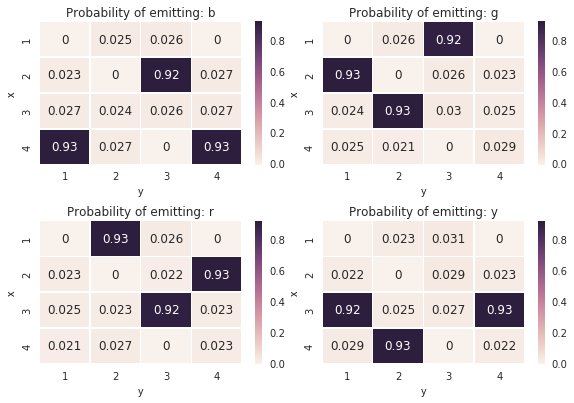

In [82]:
plot_probabilities(B_)

The above obtained probabilities are Maximum Likelihood Estimators of the true probabilities. They are point estimates. They do not take into account data not seen previously. A better estimator would the the MAP estimate or a Bayesian estimate where we even obtain a confidence interval of the probabilities.

# Viterbi Algorithm

In [89]:
O = test_data[0][['col', 'state']]

In [94]:
delta = pd.DataFrame(index=S)
psi = pd.DataFrame(index=S)

### Initialisation:

In [95]:
delta[0] = pd.Series(data=pi*B[O['col'][0]], index=S)
psi[0] = pd.Series(np.zeros(S.size), index=S)

### Recursion:

In [108]:
for t, o in enumerate(O['col'], 1):
    delta[t] = pd.Series(np.zeros(S.size), index=S)
    psi[t] = pd.Series(np.zeros(S.size), index=S)
    for j in S:
#         print(delta[t-1], A[j])
        delta.ix[j, t] = (delta[t - 1]*A[j]).max() * B.ix[j, o]
        psi.ix[j, t] = (delta[t - 1]*A[j]).idxmax()

### Termination:

In [112]:
T = O.shape[0] - 1
P = delta[T].max()
q_T = delta[T].idxmax()

In [115]:
opt_state_seq = np.zeros(O.shape[0], dtype=int)
opt_state_seq[T] = q_T
for t in range(T-1, -1, -1):
    opt_state_seq[t] = psi[t+1][opt_state_seq[t+1]]

In [116]:
print(opt_state_seq)

[ 3  3  1  1  3  1  1  1  7  1  7  3  3  3  2  3  2  1  1  1  1 14 15 14  1
 14 14  1 13 13 14 15 15 15 14 14 14 13 13 15  1 13 13 13  1  1 13 14  1  1
  3 13 13  8 14  1 14 13  1  1  1  1 14 14 15 15 14  1  7  1 14 15 14 13 14
 14 14 14 14  1 14 14  1  1  7  1 13  1  1 13 13 15 15 15 13  1 13 13  1  1
  7  1  1  1  1  1  1  1  1  1  3  3  3  2  3 13  8 14 14 14 14 15 14 14  3
  2  3  3  2  3  3  3  3  2  1  1  1  1  1  1  7  1  1  1 14 13 14  1  1  7
  1 14 15 15 13 13 13 13 13 13 13 14 13 14 13 13 13 14 13 13 14 13 13 14 13
 13 15 15 13 13 15 13 15  1  1  3  3  3  1  1  1  1  1  3  2  3  3  3  1  1]


Putting it all together:

In [117]:
def viterbi(O, A, B, pi):
    delta = pd.DataFrame(index=S)
    psi = pd.DataFrame(index=S)

    delta[0] = pd.Series(data=pi*B[O['col'][0]], index=S)
    psi[0] = pd.Series(np.zeros(S.size), index=S)

    for t, o in enumerate(O['col'], 1):
        delta[t] = pd.Series(np.zeros(S.size), index=S)
        psi[t] = pd.Series(np.zeros(S.size), index=S)
        for j in S:
    #         print(delta[t-1], A[j])
            delta.ix[j, t] = (delta[t - 1]*A[j]).max() * B.ix[j, o]
            psi.ix[j, t] = (delta[t - 1]*A[j]).idxmax()

    T = O.shape[0] - 1
    P, q_T = delta[T].max(), delta[T].idxmax()

    opt_state_seq = np.zeros(O.shape[0], dtype=int)
    opt_state_seq[T] = q_T
    for t in range(T-1, -1, -1):
        opt_state_seq[t] = psi[t+1][opt_state_seq[t+1]]
        
    return P, opt_state_seq

In [127]:
pred_seq = pd.DataFrame()
for i in range(test_data.shape[0]-1):
    O = test_data[i][['col', 'state']]
    _, pred_seq[i] = viterbi(O, A, B, pi)

In [135]:
true_seq = test_data[:199, :, 'state']
acc = true_seq.values - pred_seq
tot_acc = acc.values[np.nonzero(errors.values)].size
print("Avg Accuracy: ", tot_acc/40000)

Avg Accuracy:  0.913775


HMM is a powerful modeling technique when the system states are partially observable and the behavior of the system is considered as autonomous. Although with being partially observable, POMDP could be an effective alternative but the nature of autonomy of the modeled system will determine the ultimate selection of Markov models. Generally system autonomy is dependent on the agent decision making ability with concern of human intervention. HMMs are variant of FSMs where the flexibility of decision process could be perfectly implemented and the selection of output is basically could be described as real system outputs and to reach for efficient performance.